In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")
def choose_top_rw(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.Rw)<=n)
def choose_top_vtotal(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.VTotal)<=n)
def choose_top(data,col="Qw", n=5, ascending=False):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending)<=n)

In [3]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_4.csv")
raw_test_data_2 = raw_test_data.drop_duplicates(subset=['Qw', 'Rw', "VTotal"])
raw_test_data_2 = raw_test_data_2.assign(isGood=raw_test_data_2.groupby("Name")["Qw"].rank(ascending=False, method='first') < 51)
raw_test_data = raw_test_data_2.assign(VwithoutGo = raw_test_data.VTotal - raw_test_data.QGO)
# raw_test_data = raw_test_data_2

In [19]:
all_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_mar05.csv")
all_data = all_data.assign(VwithoutGo = all_data.VTotal - all_data.QGO)
raw_test_data_2 = all_data
raw_test_data_2 = all_data.assign(isGood=raw_test_data_2.groupby("Name")["Qw"].rank(ascending=False, method='first') < 6)
raw_test_data = raw_test_data_2.assign(VwithoutGo = raw_test_data_2.VTotal - raw_test_data_2.QGO)

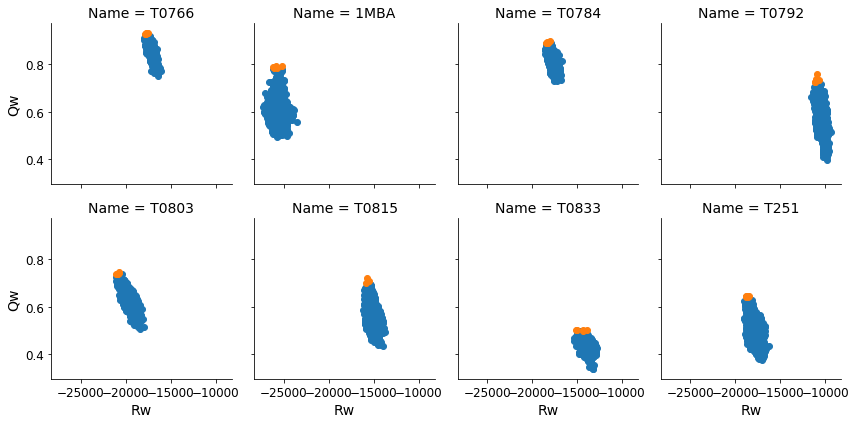

In [21]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "Rw", "Qw")

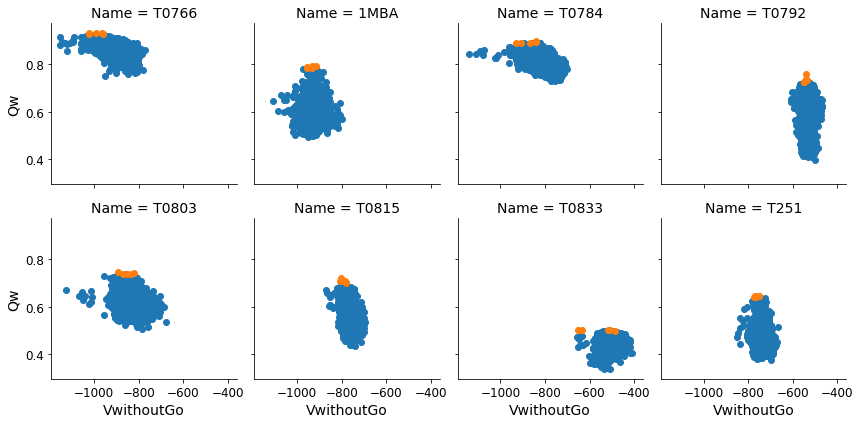

In [22]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "VwithoutGo", "Qw")

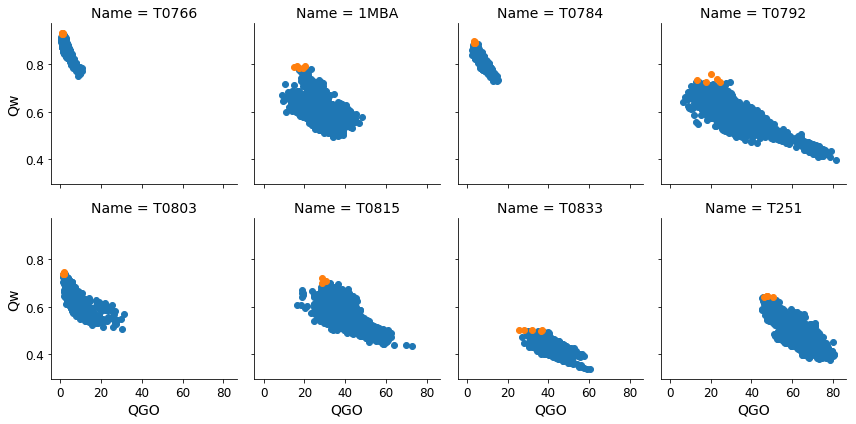

In [23]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "QGO", "Qw")

In [24]:
FEATURES = ['Rw',
#      'VTotal',
     'QGO',
     'VwithoutGo',
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
n = 5
def my_transform(data, label, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

def my_transform_predict(data, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    PolynomialDegree = degree

    num_attribs = FEATURES
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    return num_pipeline.fit_transform(data)

In [25]:
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
# raw_data = raw_data_T0792
# raw_data = raw_test_data.groupby("Name").get_group("1mba")
raw_data = raw_data_T0784


In [26]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
def train_and_test(raw_data, label="Qw", degree=1, p=0.1):
    # my_full_pipeline = Pipeline([
    # #         ('removeFirstFrame', RemoveFirstFrame(frame)),
    #         ('featureSelection', full_pipeline)
    # ])

    from sklearn.model_selection import StratifiedShuffleSplit

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=142)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_transform(strat_train_set, label, degree)
    X_test = my_transform(strat_test_set, label, degree)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]
    return (train_set, train_y, test_set, test_y)

In [27]:
label = "isGood"
degree = 1
p = 0.1
train_set, train_y, test_set, test_y = train_and_test(raw_data, label=label, degree=degree)
log_clf = LogisticRegression(random_state=140, penalty='l2')

# log_clf = LogisticRegression(random_state=14, class_weight={0:p, 1:(1-p)}, penalty='l1')
log_clf.fit(train_set, train_y)
y_pred = log_clf.predict(train_set)
# n = 100
prediction_list = []
for name, data in raw_test_data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
    X = my_transform(data, label, degree)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = raw_test_data.assign(prediction=prediction.values)
best_by_prediction = t.groupby("Name").apply(choose_top, n=n, col="prediction").query("chosen==True")

1MBA
T0766
T0784
T0792
T0803
T0815
T0833
T251


In [28]:
print(*(zip(FEATURES, log_clf.coef_[0])))

('Rw', -0.26172648454510883) ('QGO', -0.57871478923113406) ('VwithoutGo', -0.081520116588173139)


In [29]:
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")

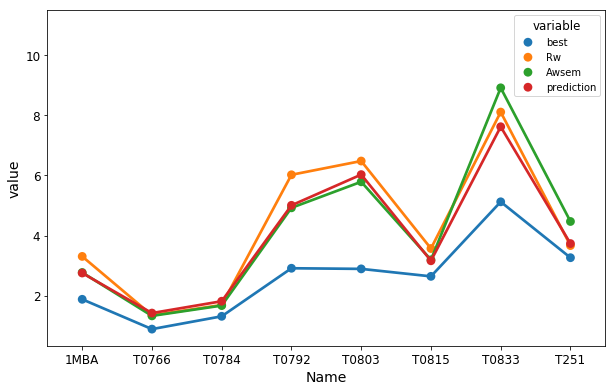

In [31]:
# T0784
label = "Rmsd"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

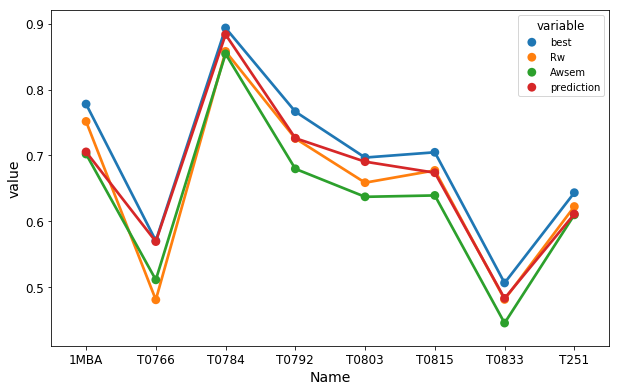

In [14]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

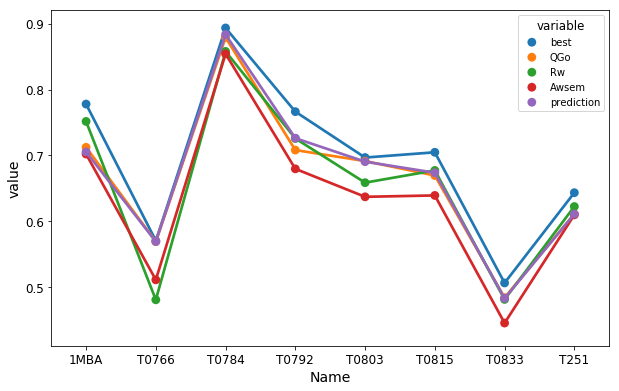

In [15]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

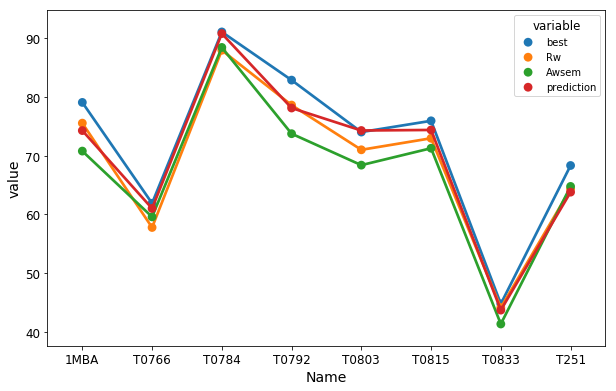

In [149]:
# T0784
label = "GDT"
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [146]:
best_by_prediction.to_csv("/Users/weilu/Research/data/structure_selector_mar03/old_best_by_prediction.csv")

In [162]:
protein_list = ["T0766", "1mba", "T0784", "T0792", "T0803", "T0815", "T0833", "T0251"]
name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB" , "Electro.", "QGO" ,"VTotal"]
all_data_list = []
for protein in protein_list:
    awsem = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar03/{protein}_awsem.log", names=name_list)
    rw = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar03/{protein}_rw.txt", names=["i", "Rw"], sep="\s+")
    rmsd = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar03/{protein}_rmsd.txt", names=["i2", "Rmsd"], sep="\s+")
    qw = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar03/{protein}_qw.txt", names=["i3", "Qw"], sep="\s+")
    rw = rw[:2000].reset_index(drop=True)
    awsem = awsem[:2000].reset_index(drop=True)
    rmsd = rmsd[:2000].reset_index(drop=True)
    qw = qw[:2000].reset_index(drop=True)
    data = pd.concat([rw, awsem, rmsd, qw], axis=1)
    remove_columns = ['i', 'i2', 'i3', 'Step', "Shake", "Excluded", "AMH_Go", "Membrane", "Vec_FM", "SSB", "Electro."]
    if protein == "T0251":
        p = "T251"
    elif protein == "1mba":
        p = "1MBA"
    else:
        p = protein
    data = data.drop(remove_columns, axis=1).reset_index().assign(Name=p)
    all_data_list.append(data)
all_data = pd.concat(all_data_list).reset_index(drop=True)

In [163]:
all_data.to_csv("/Users/weilu/Research/data/test_data/test_data_mar05.csv")

In [164]:
all_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_mar05.csv")
all_data = all_data.assign(VwithoutGo = all_data.VTotal - all_data.QGO)

In [165]:
prediction_list = []
for name, data in all_data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
    X = my_transform_predict(data, degree=1)
    eval_set = X
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = all_data.assign(prediction=prediction.values)
best_by_prediction = t.groupby("Name").apply(choose_top, n=n, col="prediction").query("chosen==True").drop('Unnamed: 0',axis=1)

1MBA
T0766
T0784
T0792
T0803
T0815
T0833
T251


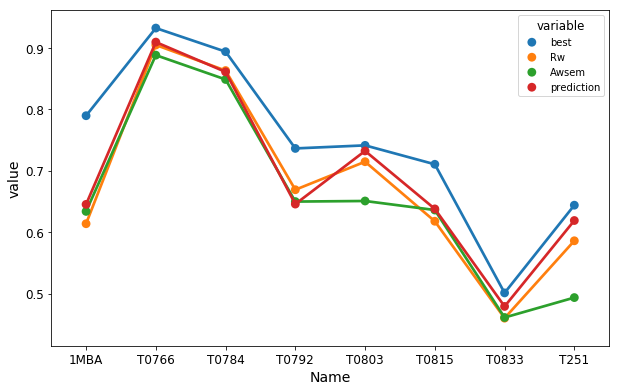

In [166]:
raw_test_data = all_data
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [19]:
best_by_prediction

index            Rw       Chain        Chi        Rama  \
Name                                                                  
1mba  3050    1050 -25668.934863  188.362784  47.568387 -623.269227   
      3063    1063 -25642.538441  193.180635  40.801919 -603.733959   
      3078    1078 -25818.058079  203.088673  39.071277 -616.459828   
      3113    1113 -26194.903471  174.845709  51.534425 -620.731595   
      3147    1147 -26212.316297  199.462767  36.102053 -614.154999   
T0251 14000      0 -19077.704744    0.000000   0.000000 -441.605335   
      14402    402 -18013.842801    0.000000   0.000000 -447.097493   
      14804    804 -18245.591771    0.000000   0.000000 -453.122289   
      15005   1005 -18000.827772    0.000000   0.000000 -427.470394   
      15809   1809 -18638.719085    0.000000   0.000000 -448.519637   
T0766 0          0 -17213.185246  115.628799  21.795659 -401.238938   
      402      402 -17460.586267  142.255390  19.363798 -404.168852   
      1005    1005 -17513.935527  160.807747  18.046265 -409.940394   
      1206    1206 -17437.085465  129.149716  22.957345 -400.999639   
      1608    1608 -17193.556092  149.790571  24.967125 -404.096143   
T0784 4311     311 -17790.388773  172.006238  42.301708 -423.169882   
      4690     690 -17779.884202  160.077993  34.527754 -429.454151   
      4694     694 -18115.408634  163.993974  27.565366 -429.295744   
      4762     762 -18261.349908  167.276551  29.235053 -433.333557   
      5597    1597 -17650.941892  181.175401  25.769981 -429.333138   
T0792 6425     425 -11114.901279    0.000000   0.000000 -300.134036   
      6426     426 -10917.058304    0.000000   0.000000 -276.838360   
      6436     436 -10781.052824    0.000000   0.000000 -281.789608   
      6437     437 -10864.652686    0.000000   0.000000 -282.437955   
      6464     464 -10961.791460    0.000000   0.000000 -261.186635   
T0803 8000       0 -19861.129034  160.995808  37.520467 -442.112608   
      8201     201 -19469.650769  173.224426  39.791078 -440.649099   
      9005    1005 -19226.886197  170.780230  30.153493 -438.148101   
      9608    1608 -19432.885521  161.641151  32.377136 -441.148114   
      9809    1809 -19464.480000  167.911743  42.869046 -444.462776   
T0815 10151    151 -15474.568755    0.000000   0.000000 -430.626865   
      10164    164 -15329.162447    0.000000   0.000000 -457.809116   
      10180    180 -15410.540183    0.000000   0.000000 -438.085216   
      10190    190 -15614.262927    0.000000   0.000000 -463.517624   
      10193    193 -15276.982093    0.000000   0.000000 -453.499118   
T0833 12000      0 -14347.027331  125.898222  23.989866 -439.957297   
      12603    603 -14701.547826  138.917304  32.995803 -443.299762   
      13005   1005 -15024.095932  149.112160  24.551428 -446.849817   
      13206   1206 -13642.710159  143.728681  30.403366 -457.602172   
      13608   1608 -15234.470919  161.067720  25.613174 -453.118256   

                  DSSP       P_AP      Water      Burial      Helix  \
Name                                                                  
1mba  3050   -0.002060  -6.122339 -51.366841 -123.306045 -55.697016   
      3063   -0.002218  -6.071182 -51.821636 -123.479884 -43.882664   
      3078   -0.005223  -6.639706 -54.863242 -123.371367 -49.869419   
      3113   -0.000000  -5.303780 -53.916686 -123.361001 -58.463907   
      3147   -0.000004  -5.832983 -59.233419 -123.518396 -53.213548   
T0251 14000 -15.255526 -13.474660 -62.605609  -96.658133 -20.929080   
      14402 -16.364849 -15.235617 -59.233454  -97.671568 -19.803157   
      14804 -15.905990 -12.362693 -61.275689  -97.947330 -21.894612   
      15005  -7.582649 -13.119749 -61.779600  -95.737925 -15.172857   
      15809 -17.481876 -15.671105 -58.833573  -96.589674 -15.501984   
T0766 0     -50.514721 -26.249246 -47.507644  -94.343514 -11.386663   
      402   -48.622003 -27.139873 -50.741840  -95.833920 -11.055376   
      1005  -50.866838 -25.586106 -4

In [32]:
best_by_prediction.to_csv("/Users/weilu/Research/data/structure_selector_mar03/best_by_prediction_based_on_new.csv")

In [171]:
a = pd.read_csv("/Users/weilu/Research/data/structure_selector_mar03/old_best_by_prediction.csv")

In [168]:
a = pd.read_csv("/Users/weilu/Research/data/structure_selector_mar03/best_by_prediction.csv")

In [165]:
for name, data in a.groupby("Name"):
    print(name)
#     print(data["index"])
    for i in data["index"]:
        print(i)

1MBA
0
108
109
185
188
T0766
2010
2274
2276
2277
2627
T0784
4677
4741
5482
5485
5622
T0792
6030
6207
6210
6212
6213
T0803
8040
8178
8201
8560
8636
T0815
10050
10454
10461
10463
11066
T0833
12060
12475
12478
13068
13071
T251
14042
15059
15102
15112
15870


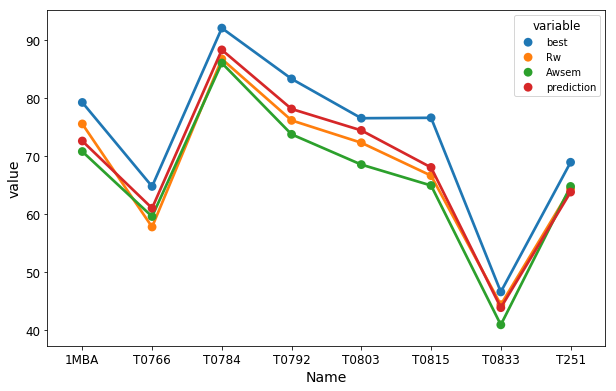

In [138]:
# T0784
label = "GDT"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

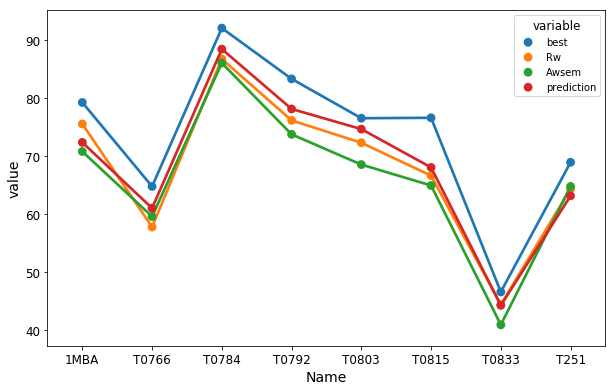

In [122]:
# T0784
label = "GDT"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

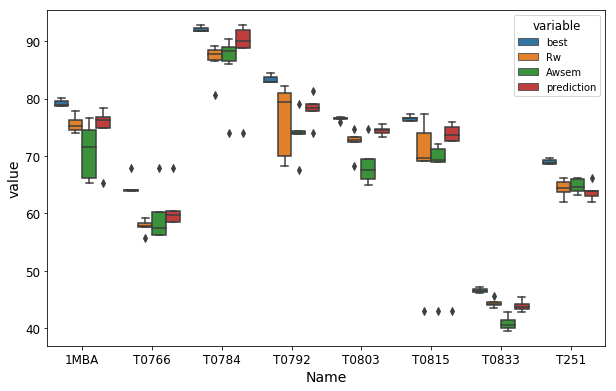

In [114]:
# T0784
label = "GDT"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.boxplot("Name","value", data=final2, hue="variable")

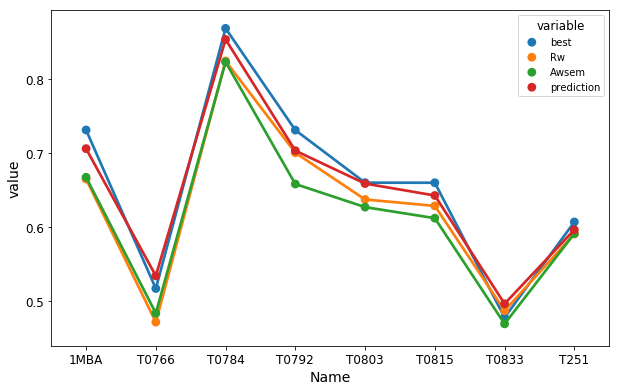

In [99]:
# T0784
label = "Qw"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

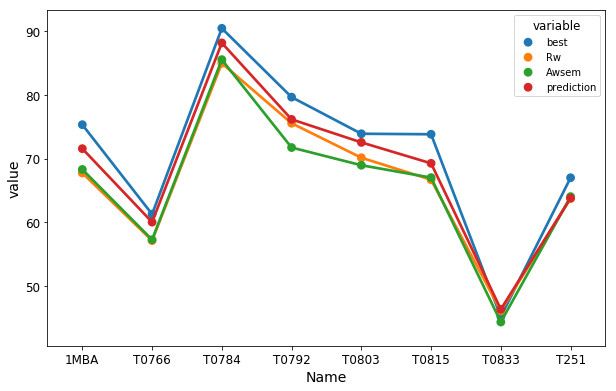

In [97]:
# T0784
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

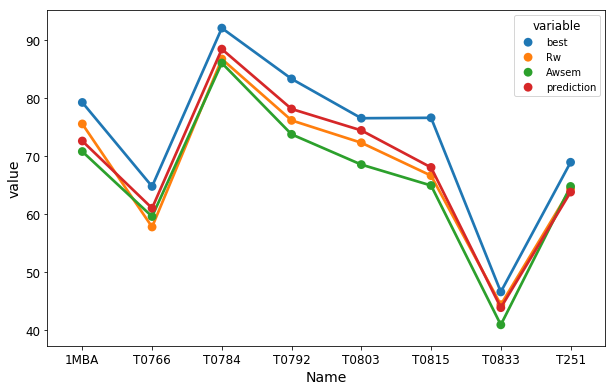

In [12]:
# T0784
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

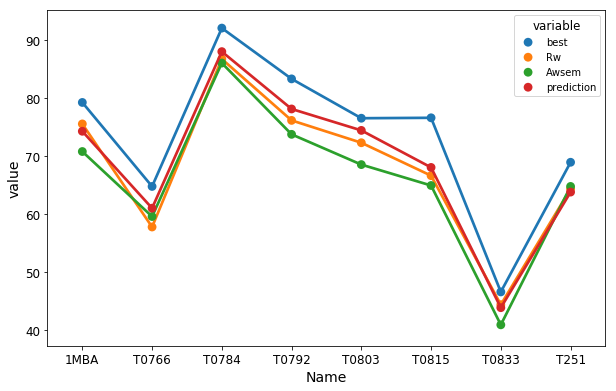

In [15]:
# T0784
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

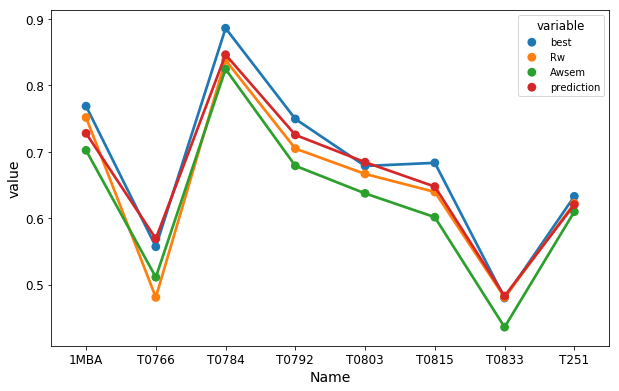

In [17]:
# T0784
label = "Qw"
a2 = best_by_GDT.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
# T0784
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
# 1mba
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
# t0792
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
final2 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
sns.pointplot("Name","value", data=final2, hue="variable", errwidth=0)

In [ ]:
sns.boxplot("Name","value", data=final2, hue="variable")

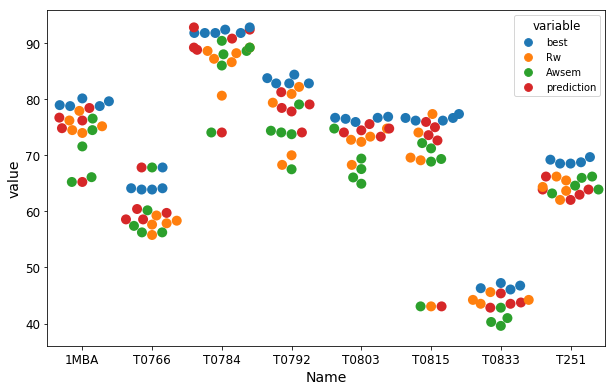

In [60]:
sns.swarmplot(x='Name', y='value', data=final2, hue="variable", size=10)

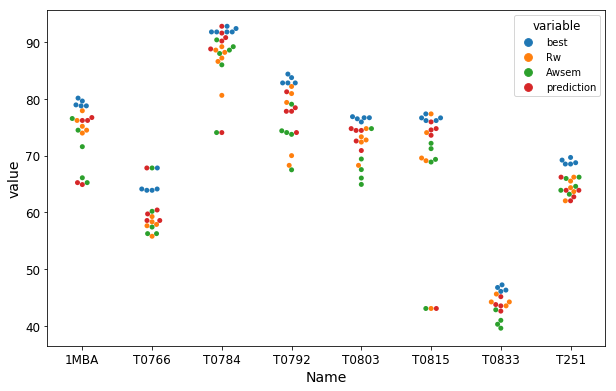

In [51]:
sns.swarmplot(x='Name', y='value', data=final2, hue="variable")

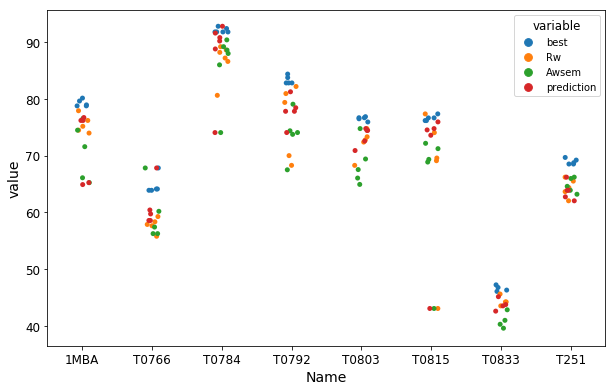

In [52]:
sns.stripplot("Name", "value", data=final2, hue="variable", jitter=True)

In [ ]:
sns.stripplot("value", "Name", data=final2, hue="variable", jitter=True)

In [ ]:
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
sns.pointplot("Name","value", data=final2, hue="variable")
# sns.stripplot("value", "Name", data=final2, hue="variable")

In [ ]:
a2 = best_by_GDT.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"best"})
b2 = top_rw.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Rw"})
c2 = top_vtotal.reset_index(drop=True)[["GDT", "Name"]].rename(index=str,columns={"GDT":"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", "GDT"]].rename(index=str,columns={"GDT":"prediction"})
final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
sns.pointplot("Name","value", data=final2, hue="variable")
# sns.stripplot("value", "Name", data=final2, hue="variable")

In [ ]:
np.sum(y_pred != train_y)

In [ ]:
prediction.shape

In [ ]:
raw_test_data.shape

In [ ]:
y_pred.shape

In [ ]:
eval_y.argsort()[-n:][::-1]

In [ ]:
n = 10
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= regr.predict(eval_set)
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1

    position_of_top_n = eval_y.argsort()[-50:][::-1]
    threshold = eval_y[position_of_top_n][-1]
    test_y = np.zeros(len(eval_y),)
    test_y[position_of_top_n] = 1
    plt.figure()
    plt.scatter(test, eval_y)
    plt.show()

#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(test_y, predict_y))

In [ ]:
plt.scatter(y_pred, train_y)

In [ ]:



from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# log_clf = LogisticRegression(random_state=142)
# rnd_clf = RandomForestClassifier(random_state=432)
# svm_clf = SVC(probability=True, random_state=412)
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
rnd_clf.fit(train_set, train_y)
svm_clf.fit(train_set, train_y)
voting_clf.fit(train_set, train_y)


# check on training set
n = 10
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     y_pred = clf.predict(train_set)
    prob= clf.predict_proba(train_set)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    predict_y = np.zeros(len(train_y),)
    predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
    cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
    print(clf.__class__.__name__, "\n", cm)
    
time_stamp = f"{datetime.today().strftime('%d_%h_%H%M%S')}"
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1

    with open(f"/Users/weilu/Research/data/structure_selector/p{p}_poly{PolynomialDegree}_{name}.csv", "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
#     with open(f"/Users/weilu/Research/data/structure_selector/{name}_results_{time_stamp}.csv", "w") as f:
#         f.write("Result\n")
#         for i in test:
#             f.write(str(i) + "\n")

#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))
print(f"p{p}_poly{PolynomialDegree}")

In [ ]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_4.csv")
raw_test_data_2 = raw_test_data.drop_duplicates(subset=['Qw', 'Rw', "VTotal"])
raw_test_data_2 = raw_test_data_2.assign(isGood=raw_test_data_2.groupby("Name")["GDT"].rank(ascending=False, method='first') < 50)
raw_test_data = raw_test_data_2
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
raw_data = raw_data_T0792

In [ ]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
FEATURES = ['Rw',
 'VTotal',
 'QGO',
 'Burial',
 'Water',
 'Rama',
 'DSSP',
 'P_AP',
 'Helix',
 'Frag_Mem']
# LABEL = "Qw"
LABEL = "isGood"
PolynomialDegree = 2
p = 0.1


num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
#         ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])
    
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]



# log_clf = LogisticRegression(random_state=142)
# rnd_clf = RandomForestClassifier(random_state=432)
# svm_clf = SVC(probability=True, random_state=412)
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})

log_clf.fit(train_set, train_y)


# check on training set
n = 5

clf = log_clf
#     y_pred = clf.predict(train_set)
prob= clf.predict_proba(train_set)[:,1]
position_of_top_n = prob.argsort()[-n:][::-1]
threshold = prob[position_of_top_n][-1]
predict_y = np.zeros(len(train_y),)
predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
print(clf.__class__.__name__, "\n", cm)



for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1
    print(confusion_matrix(eval_y, predict_y))
print(f"p{p}_poly{PolynomialDegree}")



In [ ]:
strat_train_set["a"] = prob

In [ ]:
strat_train_set.plot("a", "GDT", kind="scatter")

In [ ]:
prob

In [ ]:
pd.concat([strat_train_set, pd.Series(prob)], axis=1)

In [ ]:
def compute_with_my_score_function(p=0.9, PolynomialDegree=3):
    FEATURES = ['Rw',
     'VTotal',
     'QGO',
     'Burial',
     'Water',
     'Rama',
     'DSSP',
     'P_AP',
     'Helix',
     'Frag_Mem']
    # LABEL = "Qw"
    LABEL = "isGood"

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    frame = 201
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    my_full_pipeline = Pipeline([
    #         ('removeFirstFrame', RemoveFirstFrame(frame)),
            ('featureSelection', full_pipeline)
    ])

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_full_pipeline.fit_transform(strat_train_set)
    X_test = my_full_pipeline.fit_transform(strat_test_set)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]

    # log_clf = LogisticRegression(random_state=142)
    # rnd_clf = RandomForestClassifier(random_state=432)
    # svm_clf = SVC(probability=True, random_state=412)
    log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
    log_clf.fit(train_set, train_y)

#     voting_clf.fit(train_set, train_y)
    n = 10
    cl_name = "lr"
    clf = log_clf
#     for cl_name, clf in ("voting", voting_clf):
    my_evaluation = 1.0
    another_evaluation = 0.0
    for name, data in raw_test_data.groupby("Name"):
#             print(name)
#         X = full_pipeline.fit_transform(data)
#         validation_data, test_data = train_test_split(X, test_size=0.6, random_state=124)
        validation_data = my_full_pipeline.fit_transform(raw_data_T0784)
        validation_y = validation_data[:,-1]
        validation_set = validation_data[:,:-1]
        clf.fit(train_set, train_y)
        test= clf.predict_proba(validation_set)[:,1]
        position_of_top_n = test.argsort()[-n:][::-1]
        threshold = test[position_of_top_n][-1]
        predict_y = np.zeros(len(validation_y),)
        predict_y[position_of_top_n] = 1
    #     predict_y = (test > threshold)
#         print(threshold)
        cm = confusion_matrix(validation_y, predict_y)
#             print(cm)
        precision = cm[1][1] / (cm[1][1] + cm[0][1])
#             print(name,  " precision", precision,end = " ")
        if name != "T0766" and name != "T0833":
            my_evaluation *= precision
            another_evaluation += precision
#         print("")
    print("classifier:", cl_name, ", p:",p, ", degree", PolynomialDegree, ", score", my_evaluation, ", another score", another_evaluation)
    return (cl_name, p, PolynomialDegree, my_evaluation)

In [ ]:
def myGridSerach():
    p_list = [0.9, 0.8, 0.7, 0.5, 0.1]
    degree_list = [3, 2, 1]
#     p_list = [0.1, 0.8, 0.9, 0.95]
#     degree_list = [1, 2, 3]
#     p_list = [0.1, 0.15, 0.2, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95]
#     degree_list = [1, 2, 3, 4]
    result = []
    for p in p_list:
        for degree in degree_list:
            result += [compute_with_my_score_function(p, degree)]
            

In [ ]:
myGridSerach()

In [ ]:
compute_with_my_score_function(0.1, 1)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")

In [ ]:
num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
#         ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# log_clf = LogisticRegression(random_state=142)
# rnd_clf = RandomForestClassifier(random_state=432)
# svm_clf = SVC(probability=True, random_state=412)
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
rnd_clf.fit(train_set, train_y)
svm_clf.fit(train_set, train_y)
voting_clf.fit(train_set, train_y)

In [ ]:
# check on training set
n = 10
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     y_pred = clf.predict(train_set)
    prob= clf.predict_proba(train_set)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    predict_y = np.zeros(len(train_y),)
    predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
    cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
    print(clf.__class__.__name__, "\n", cm)

In [ ]:
time_stamp = f"{datetime.today().strftime('%d_%h_%H%M%S')}"
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1

    with open(f"/Users/weilu/Research/data/structure_selector/p{p}_poly{PolynomialDegree}_{name}.csv", "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
#     with open(f"/Users/weilu/Research/data/structure_selector/{name}_results_{time_stamp}.csv", "w") as f:
#         f.write("Result\n")
#         for i in test:
#             f.write(str(i) + "\n")

#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))

In [ ]:
time_stamp = f"{datetime.today().strftime('%d_%h_%H%M%S')}"
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = my_full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1


#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))